## Noiseless Simulation

In this notebook, you will find the qiskit-version implementation of the algorithm mentioned in this [paper](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.010318) on a noiseless simulator.

In [12]:
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline

#from scipy.special import iv
#from scipy.linalg import expm, block_diag
#from scipy import integrate
#from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister
from qiskit import Aer, transpile
from qiskit.circuit import Parameter
#from qiskit.providers.fake_provider import FakeGuadalupe, FakeNairobi
#from qiskit.visualization import plot_histogram

from HA_utils import Assembly_ACDF, get_real_CDF, get_fh_matrix

import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Main story

**Problem: Estimating ground-state energy using cumulative distribution function**

Problem setting: Assume a Hamiltonian $H=\sum^{K-1}_{i=0}\lambda_i \Pi_i$ in a increasing eigenvalue order, where $\lambda_i$ is the $i$th eigenvalue(energy) and $\Pi_i$ is the $i$th projector associated with $\lambda_i$. We want to find out the smallest eigenvalue (ground-state energy) $\lambda_0$.

**Scaling factor**

The algorithm complexity mainly depends on two parameter:

1. $p_0$ overlap between the input state $\rho$ and the ground-state energy. $p_0 = {\rm Tr}(\rho \Pi_0)$ 
2. $\epsilon$ accuracy requirement for the energy estimation.$|\lambda_0 - \tilde{\lambda_0}|<\epsilon$

In the proposed algorithm, their total runtime is $O(\epsilon^{-1} poly(p_0^{-1}))$ and their maximal evolution time is $O(\epsilon^{-1} polylog(\epsilon^{-1}p_0^{-1}))$

**Hadamard Test**

In the scenario of Hadamard test, we can evaluate the Real/Image part of the trace of a unitary operator $U$ on a state $\rho$ with only one additional ancilla qubit. By enough sampling, we can get ${\rm ReTr}(\rho U)$ and ${\rm ImTr}(\rho U)$.

### Step-by-Step

First, we use a scaling factor $\tau$ such that $\tau ||H||<\pi/3$.

We write the spectrum of $\tau ||H||$ out: $p(x) = \sum^{K-1}_{i=0}p_k\delta(x-\tau \lambda_k)$. Notice that p(x) is supported in $(-\pi/3, \pi/3)$.

Given the spectrum, we can define the Cumulative Distribution Function (CDF) as 
$$C(x) = (H\star p)(x) = \int^{\pi}_{-\pi} H(y)p(x-y)dy =\sum_{k, \lambda_k\leq x}p_k$$ 
where $H(x)$ is the Hiverside step function defined periodically
$$H(x) = 1 , x\in[2k\pi,(2k+1)\pi) ;  0, x\in[(2k-1)\pi,2k\pi)$$

If we can evaluate $C(x)$ and find the first point $x^\star$ it jumps to a non-zero value, we find the ground-state energy. However, it's hard to evaluate $C(x)$ directly. So we use $\tilde{C}(x)$ (Approximate CDF, ACDF) to approximate $C(x)$. To see it, we first define the approximate Hiverside function
$$
F(x)=\sum_{|j|<=d} \hat{F}_j e^{ijx}
$$
And we have $|F(x)-H(x)|<\epsilon$ in most of the range $(-\pi, \pi)$. 

Please refer to [this notebook](F_list_calculation.ipynb) for the code to calculate $F_j$.
Consequently, the ACDF is defined as
$$
\tilde{C}(x) = (F\star p)(x) = \sum_{|j|\leq d} \hat{F}_j e^{ijx} Tr(\rho e^{-ij\tau H})
$$

How to get $\tilde{C}(x)$? If we sample it using Hadamard test for all terms directly, the complexity scaling is not really good. Instead, we also sample different terms $j$ randomly using a random vairable $J$ 
$$ Pr[J=j]=\frac{|\hat{F}_j|}{\mathcal{F}}
$$
where $\mathcal{F} = \sum_{|j|\leq d}|\hat{F}_j|$. Therefore, we can use $G(x;J,Z)$ to estimate $\tilde{C}(x)$
$$ G(x;J,Z) = \mathcal{F}Z e^{i(\theta_J+ Jx)}
$$
where $Z= X + i Y \in {\pm 1 \pm i}$ is the estimator of $Tr(\rho e^{-ij\tau H})$ using Hadamard test. By taking average of multishots, we can have such an estimation:
$$ \tilde{C} \approx \bar{G} = \frac{1}{N_s}\sum^{N_s}_{k=1}G(x;J_k, Z_k)
$$

Now we have the expression of ACDF, we can evaluate it using binary search and locate the ground-state energy.

## Problem

In our implementation, we mainly focus on the Half-fill Fermi-Hubbard Model. The Hamiltonian description can be found in the Appendix F of the paper. The Hamiltonian forms like
$$
H = -\frac{t}{2} \sum_{j,\sigma}(X_{j,\sigma}X_{j+1,\sigma}+Y_{j,\sigma}Y_{j+1,\sigma}) + \frac{U}{4} \sum_j Z_{j,\uparrow}Z_{j,\downarrow}
$$

For half-fill, the asymmetric initial hatree-fock state is

$$
\ket{100110011001..}
$$

and the symmetric initial state is 
$$
\frac{(\ket{100110011001..}+\ket{011001100110..})}{\sqrt{2}}
$$

## Compose the required Quantum Circuit

Instead of the circuit proposed in the main text, we use the circuit with two ancilla qubits as shown in Appedix E. This circuit uses two ancillas but doesn't require a Control-Evolution gate, which is more suitable for NISQ device.

We construct the trottered evolution gate with `fh_evolution_trotter` and prepare initial state with `initial_state_prep`.

In [13]:
def fh_evolution_trotter(N_sites, t, U, tau, j, step, to_gate=True):
    
    qr = QuantumRegister(2*N_sites,'qr')
    qc = QuantumCircuit(qr)
    
    for _ in range(step):
        
        ## Hopping terms 
        theta = tau*t*j/step
        
        for i in range(N_sites//2):
            qc.rxx(theta,2*i,2*i+1)
            qc.ryy(theta,2*i,2*i+1)

            qc.rxx(theta,2*i+N_sites,2*i+1+N_sites)
            qc.ryy(theta,2*i+N_sites,2*i+1+N_sites)
            
        for i in range((N_sites-1)//2):
            qc.rxx(theta,2*i+1,2*i+2)
            qc.ryy(theta,2*i+1,2*i+2)

            qc.rxx(theta,2*i+N_sites+1,2*i+2+N_sites)
            qc.ryy(theta,2*i+N_sites+1,2*i+2+N_sites)
        
        ## Potential
        gamma = tau*j*U/(2*step)
        
        for i in range(N_sites):
            qc.rzz(gamma,i,i+N_sites)
    return qc.to_gate() if to_gate else qc

def initial_state_prep(N_sites, initial_state_symmetry=True, to_gate=True):

    qr = QuantumRegister(2*N_sites,'q')
    qc = QuantumCircuit(qr)

    if initial_state_symmetry:
        qc.h(0)
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)

        qc.cnot(0,range(1,2*N_sites))

    else:
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)
        

    return qc.to_gate() if to_gate else qc

In [14]:
# If you wanna see how the trotterized evolution gate looks like, try the below

#fh_evolution_trotter(N_sites=4, t=1, U=4, 1, j, step, to_gate=True)

`get_new_Hadamard_circuit` returns the required circuit for our algorithm, and `get_new_Hadamard_circuit_para` returns the parametrized circuit for our algorithm. The simulator will run faster if we use a parameterized circuit as it will save time for transpilation.

In [15]:
def get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=True,test_type='real'):

    qr = QuantumRegister(2*N_sites+2,'q')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution_trotter(N_sites=N_sites, t=t, U=U, tau=tau, j=j, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    return qc

In [16]:
def get_new_Hadamard_circuit_para(N_sites, theta_para, gamma_para, step, initial_state_symmetry=True,test_type='real'):

    def fh_evolution_para(N_sites, theta_para, gamma_para, step, to_gate=True):
    
        qr = QuantumRegister(2*N_sites,'qr')
        qc = QuantumCircuit(qr)
        
        for _ in range(step):
            
            ## Hopping terms 
            #theta = tau*t*j/step
            #theta = Parameter('theta')
            
            for i in range(N_sites//2):
                qc.rxx(theta_para,2*i,2*i+1)
                qc.ryy(theta_para,2*i,2*i+1)

                qc.rxx(theta_para,2*i+N_sites,2*i+1+N_sites)
                qc.ryy(theta_para,2*i+N_sites,2*i+1+N_sites)
                
            for i in range((N_sites-1)//2):
                qc.rxx(theta_para,2*i+1,2*i+2)
                qc.ryy(theta_para,2*i+1,2*i+2)

                qc.rxx(theta_para,2*i+N_sites+1,2*i+2+N_sites)
                qc.ryy(theta_para,2*i+N_sites+1,2*i+2+N_sites)
            
            ## Potential
            #gamma = tau*j*U/(2*step)
            #gamma = Parameter('gamma')
            
            for i in range(N_sites):
                qc.rzz(gamma_para,i,i+N_sites)
        return qc.to_gate() if to_gate else qc

    qr = QuantumRegister(2*N_sites+2,'q')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution_para(N_sites=N_sites, theta_para=theta_para, gamma_para=gamma_para, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    return qc 

Given a number for total sample shots and calculated F coefficient, `get_shots_per_run` will sample the shots per circuit run. `get_Z_list` and `get_new_Z` help return the sampled Z value, which will be used to assemble the ACDF function with the F coefficient. `get_Z_list_para` do the same thing but use the parameterized circuit and value binding, and it's tested to run faster than the original one.

In [17]:
def get_new_Z(N_sites, t, U, tau, j, step, shots, initial_state_symmetry=True):

    qc_real = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='real')
    qc_imag = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='imag')
    backend=Aer.get_backend('qasm_simulator')

    #start=time.time()
    qc_real = transpile(qc_real,backend)
    qc_imag = transpile(qc_imag,backend)
    #end=time.time()
    #print('time transpile: ', end-start)
    job_real = backend.run(qc_real,shots=shots)
    job_imag = backend.run(qc_imag,shots=shots)
    
    counts_real = job_real.result().get_counts()
    counts_imag = job_imag.result().get_counts()

    p00, p01, p10, p11 = 0,0,0,0
    if ('0'*2*N_sites+'00') in counts_real.keys():
        p00 = counts_real['0'*2*N_sites+'00']/shots
    if ('0'*2*N_sites+'01') in counts_real.keys():
        p01 = counts_real['0'*2*N_sites+'01']/shots
    if ('0'*2*N_sites+'10') in counts_real.keys():
        p10 = counts_real['0'*2*N_sites+'10']/shots
    if ('0'*2*N_sites+'11') in counts_real.keys():
        p11 = counts_real['0'*2*N_sites+'11']/shots

    X = p00+p11-p01-p10

    p00, p01, p10, p11 = 0,0,0,0
    if ('0'*2*N_sites+'00') in counts_imag.keys():
        p00 = counts_imag['0'*2*N_sites+'00']/shots
    if ('0'*2*N_sites+'01') in counts_imag.keys():
        p01 = counts_imag['0'*2*N_sites+'01']/shots
    if ('0'*2*N_sites+'10') in counts_imag.keys():
        p10 = counts_imag['0'*2*N_sites+'10']/shots
    if ('0'*2*N_sites+'11') in counts_imag.keys():
        p11 = counts_imag['0'*2*N_sites+'11']/shots

    Y = p00+p11-p01-p10

    lambda_R = U/4*N_sites

    Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
    return Z

def get_shots_per_run(F_list, total_shots,type='sample'):

    F_list_abs = np.array([np.abs(ele) for ele in F_list])
    probs = F_list_abs/sum(F_list_abs)
    if type=='sample':
        sampling = np.random.choice(range(len(probs)), size=int(total_shots), p=probs)
        counter = Counter(sampling)

        shots_list = np.zeros(len(probs),dtype=int)
        for i in range(len(probs)):
            shots_list[i] = int(counter[i])
    elif type=='distribution':
        shots_list = np.round(total_shots*probs)
    return shots_list

def get_Z_list(d, N_sites, t, U, tau, step, shots_list, initial_state_symmetry=True): ## shots_per_run should be replaced
    
    #Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list) for j in range(d+1)]

    Z_list = np.zeros(d+1,dtype='complex')
    for j in range(d+1):
        if shots_list[j]:
            Z_list[j] = get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list[j],initial_state_symmetry=initial_state_symmetry)
    return Z_list


def get_Z_list_para(d, N_sites, t, U, tau, step, shots_list, initial_state_symmetry=True): ## shots_per_run should be replaced
    
    #Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list) for j in range(d+1)]
    theta = Parameter('theta')
    gamma = Parameter('gamma')
    circuit_para_real = get_new_Hadamard_circuit_para(N_sites=N_sites, theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry,test_type='real')
    circuit_para_imag = get_new_Hadamard_circuit_para(N_sites=N_sites, theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry,test_type='imag')
    backend=Aer.get_backend('qasm_simulator')

    circuit_real_transpiled = transpile(circuit_para_real,backend)
    circuit_imag_transpiled = transpile(circuit_para_imag,backend)
    Z_list = np.zeros(d+1,dtype='complex')
    for j in range(d+1):
        if shots_list[j]:
            shots = shots_list[j]
            theta_value = tau*t*(2*j+1)/step
            gamma_value = tau*U*(2*j+1)/(2*step)
            circuit_real_binded = circuit_real_transpiled.bind_parameters({theta:theta_value,gamma:gamma_value})
            circuit_imag_binded = circuit_imag_transpiled.bind_parameters({theta:theta_value,gamma:gamma_value})
            job_real = backend.run(circuit_real_binded,shots=shots)
            job_imag = backend.run(circuit_imag_binded,shots=shots)

            counts_real = job_real.result().get_counts()
            counts_imag = job_imag.result().get_counts()

            p00, p01, p10, p11 = 0,0,0,0
            if ('0'*2*N_sites+'00') in counts_real.keys():
                p00 = counts_real['0'*2*N_sites+'00']/shots
            if ('0'*2*N_sites+'01') in counts_real.keys():
                p01 = counts_real['0'*2*N_sites+'01']/shots
            if ('0'*2*N_sites+'10') in counts_real.keys():
                p10 = counts_real['0'*2*N_sites+'10']/shots
            if ('0'*2*N_sites+'11') in counts_real.keys():
                p11 = counts_real['0'*2*N_sites+'11']/shots

            X = p00+p11-p01-p10

            p00, p01, p10, p11 = 0,0,0,0
            if ('0'*2*N_sites+'00') in counts_imag.keys():
                p00 = counts_imag['0'*2*N_sites+'00']/shots
            if ('0'*2*N_sites+'01') in counts_imag.keys():
                p01 = counts_imag['0'*2*N_sites+'01']/shots
            if ('0'*2*N_sites+'10') in counts_imag.keys():
                p10 = counts_imag['0'*2*N_sites+'10']/shots
            if ('0'*2*N_sites+'11') in counts_imag.keys():
                p11 = counts_imag['0'*2*N_sites+'11']/shots

            Y = p00+p11-p01-p10

            lambda_R = U/4*N_sites

            Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*(2*j+1)*tau)
            Z_list[j] = Z

    return Z_list

## Number of shots

First, we are interested in the effect of total sample shots on the ACDF function. We set `total_shots` to be [3000, 5000, 10000, 20000]. We halfed the value in our code because we need to divide the shots for real and imag evaluation. 

In [23]:
N_sites = 4
t = 1
U = 4
step = 100
#total_shots=1500
precision = 20000
initial_state_symmetry=True
total_shots_list = [1500, 2500, 5000, 10000]

#F_list_import = np.load('F_list/F_list_d2e3_lim2e3_delta4.npy')
F_list_import=np.load('F_list/F_list_d2e4_lim1e4.npy')
d = 20000


fh_matrix = get_fh_matrix(N_sites=N_sites, t=t, U=U)
tau = 3*pi/(4*np.linalg.norm(fh_matrix))


ACDF_list = []
for total_shots in total_shots_list:
    shots_list = get_shots_per_run(F_list=F_list_import,
                                total_shots=total_shots)

    # Z_list = get_Z_list(d=d, N_sites=N_sites, t=t, U=U,
    #                     tau=tau, step=step, shots_list=shots_list,
    #                     initial_state_symmetry=initial_state_symmetry)
    
    Z_list = get_Z_list_para(d=d, N_sites=N_sites, t=t, U=U, tau=tau, step=step,
                            shots_list=shots_list, initial_state_symmetry=initial_state_symmetry)

    ACDF = Assembly_ACDF(Z_list=Z_list, F_list=F_list_import, precision=precision)
    ACDF_list.append(ACDF)

CDF = get_real_CDF(N_sites=N_sites,t=t,U=U,tau=tau,initial_state_symmetry=initial_state_symmetry,precision=precision)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


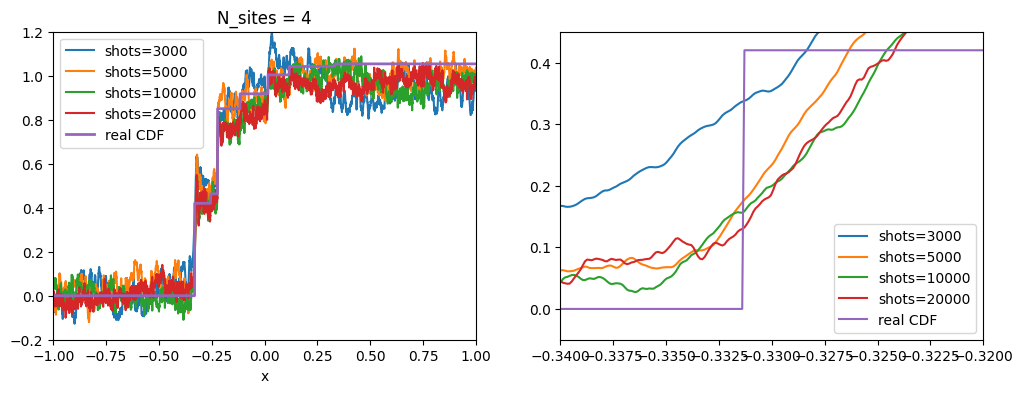

In [19]:
x_list = np.linspace(-pi/3,pi/3,precision)
fig, ax = plt.subplots(1,2,figsize=(12,4))

for i in range(len(total_shots_list)):
    ax[0].plot(x_list,ACDF_list[i],label='shots='+str(total_shots_list[i]*2))
ax[0].plot(x_list, CDF ,label='real CDF',linewidth=2)
ax[0].legend()
ax[0].set_xlabel('x')
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-0.2,1.2])
ax[0].set_title('N_sites = '+str(N_sites))

for i in range(len(total_shots_list)):
    ax[1].plot(x_list,ACDF_list[i],label='shots='+str(total_shots_list[i]*2))
ax[1].plot(x_list, CDF,label='real CDF')
ax[1].set_xlim([-0.34,-0.32])
# ax[1].hlines(.21, -0.34, -0.32,linestyles='dashdot')
# ax[1].vlines(-0.3308, -1, 0.21,linestyles='dashed',label='-0.3308')
# ax[1].vlines(-0.33135, -1, 0,linestyles='dashed',colors='orange')
ax[1].legend()
#ax[1].set_xlim([-0.11,-0.08])
#ax[1].vlines(-0.0964,-1,0)
#ax[1].vlines(-0.1012,-1,0,linestyles='dashed',colors='orange',label='-.10093')
#ax[1].vlines(-0.1005,-1,0.18,linestyles='dashed',label='-.1005')
#ax[1].hlines(0.177,-0.11,0,linestyles='dashdot')
#ax[1].set_xticks([-.34,-.33135,-.32])
#ax[1].set_xticks([-.11,-.08])
#ax[1].text(.01,.01,'-0.3313')
ax[1].set_ylim([-0.05,0.45])
#ax[1].set_xlabel('x')
ax[1].legend()


Let's focus on two specific shot number and run for a repitition of 10 times.

In [38]:
N_sites = 4
t = 1
U = 4
step = 10
#total_shots=1500
precision = 20000
initial_state_symmetry=True
total_shots_list = [1500, 5000, 10000]
rep = 10

#F_list_import = np.load('F_list/F_list_d2e3_lim2e3_delta4.npy')
F_list_import=np.load('F_list/F_list_d2e4_lim1e4.npy')
d = 20000


fh_matrix = get_fh_matrix(N_sites=N_sites, t=t, U=U)
tau = 3*pi/(4*np.linalg.norm(fh_matrix))


ACDF_list = []
for total_shots in total_shots_list:

    ACDF_partial_list = []
    for _ in range(rep):
        shots_list = get_shots_per_run(F_list=F_list_import,
                                    total_shots=total_shots)

        # Z_list = get_Z_list(d=d, N_sites=N_sites, t=t, U=U,
        #                     tau=tau, step=step, shots_list=shots_list,
        #                     initial_state_symmetry=initial_state_symmetry)
        
        Z_list = get_Z_list_para(d=d, N_sites=N_sites, t=t, U=U, tau=tau, step=step,
                                shots_list=shots_list, initial_state_symmetry=initial_state_symmetry)

        ACDF = Assembly_ACDF(Z_list=Z_list, F_list=F_list_import, precision=precision)
        ACDF_partial_list.append(ACDF)
    ACDF_list.append(ACDF_partial_list)

CDF = get_real_CDF(N_sites=N_sites,t=t,U=U,tau=tau,initial_state_symmetry=initial_state_symmetry,precision=precision)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


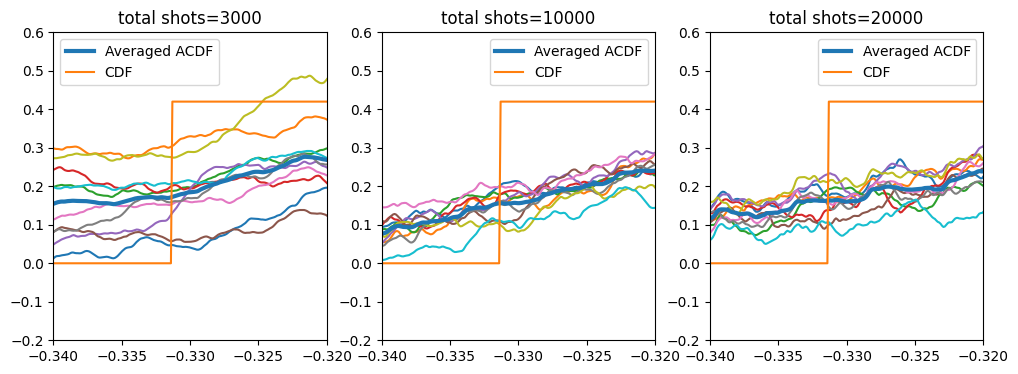

In [47]:
fig, ax = plt.subplots(1,len(ACDF_list),figsize=(12,4))
x_list = np.linspace(-pi/3,pi/3,precision)

for i in range(len(ACDF_list)):
    for j in range(rep):
        ax[i].plot(x_list, ACDF_list[i][j])
    ax[i].plot(x_list, np.mean(ACDF_list[i],axis=0),linewidth=3,label='Averaged ACDF')
    ax[i].set_title('total shots='+str(total_shots_list[i]*2))
    ax[i].plot(x_list, CDF,label='CDF')
    ax[i].set_xlim([-.34,-.32])
    ax[i].set_ylim([-.2,.6])
    ax[i].legend()

# Trotterization Step

We are also interested in the effect of trotterization error on our algorithm. We set trotterization step to be [1, 10, 50, 100] and see.

In [209]:
N_sites = 4
t = 1
U = 4
#step = 100
total_shots=5000
precision = 20000
initial_state_symmetry=True
step_list = [1, 10, 50, 100]

#F_list_import = np.load('F_list/F_list_d2e3_lim2e3_delta4.npy')
F_list_import=np.load('F_list/F_list_d2e4_lim1e4.npy')
d = 20000


fh_matrix = get_fh_matrix(N_sites=N_sites, t=t, U=U)
tau = 3*pi/(4*np.linalg.norm(fh_matrix))


ACDF_list = []
for step in step_list:
    shots_list = get_shots_per_run(F_list=F_list_import,
                                total_shots=total_shots)

    # Z_list = get_Z_list(d=d, N_sites=N_sites, t=t, U=U,
    #                     tau=tau, step=step, shots_list=shots_list,
    #                     initial_state_symmetry=initial_state_symmetry)
    
    Z_list = get_Z_list_para(d=d, N_sites=N_sites, t=t, U=U, tau=tau, step=step,
                             shots_list=shots_list, initial_state_symmetry=initial_state_symmetry)

    ACDF = Assembly_ACDF(Z_list=Z_list, F_list=F_list_import, precision=precision)
    ACDF_list.append(ACDF)

CDF = get_real_CDF(N_sites=N_sites,t=t,U=U,tau=tau,initial_state_symmetry=initial_state_symmetry,precision=precision)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


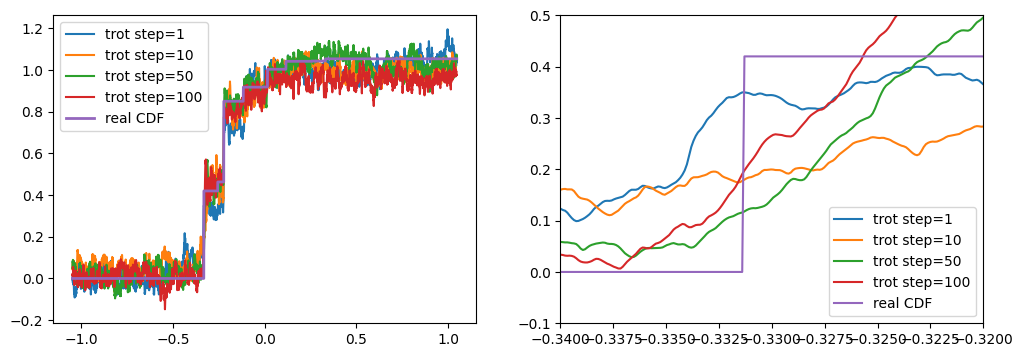

In [216]:
x_list = np.linspace(-pi/3,pi/3,precision)
fig, ax = plt.subplots(1,2,figsize=(12,4))

for i in range(len(step_list)):
    ax[0].plot(x_list,ACDF_list[i],label='trot step='+str(step_list[i]))
ax[0].plot(x_list, CDF ,label='real CDF',linewidth=2)
ax[0].legend()

for i in range(len(total_shots_list)):
    ax[1].plot(x_list,ACDF_list[i],label='trot step='+str(step_list[i]))
ax[1].plot(x_list, CDF,label='real CDF')
ax[1].set_xlim([-0.34,-0.32])
ax[1].set_ylim([-0.1,0.5])
ax[1].legend()


In [48]:
N_sites = 4
t = 1
U = 4
#step = 100
total_shots=5000
precision = 20000
initial_state_symmetry=True
step_list = [1, 10, 100]
rep = 10

#F_list_import = np.load('F_list/F_list_d2e3_lim2e3_delta4.npy')
F_list_import=np.load('F_list/F_list_d2e4_lim1e4.npy')
d = 20000


fh_matrix = get_fh_matrix(N_sites=N_sites, t=t, U=U)
tau = 3*pi/(4*np.linalg.norm(fh_matrix))


ACDF_list = []
for step in step_list:
    shots_list = get_shots_per_run(F_list=F_list_import,
                                total_shots=total_shots)

    ACDF_partial_list = []
    for i in range(rep):
    
        Z_list = get_Z_list_para(d=d, N_sites=N_sites, t=t, U=U, tau=tau, step=step,
                                shots_list=shots_list, initial_state_symmetry=initial_state_symmetry)

        ACDF = Assembly_ACDF(Z_list=Z_list, F_list=F_list_import, precision=precision)
        ACDF_partial_list.append(ACDF)

    ACDF_list.append(ACDF_partial_list)


CDF = get_real_CDF(N_sites=N_sites,t=t,U=U,tau=tau,initial_state_symmetry=initial_state_symmetry,precision=precision)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


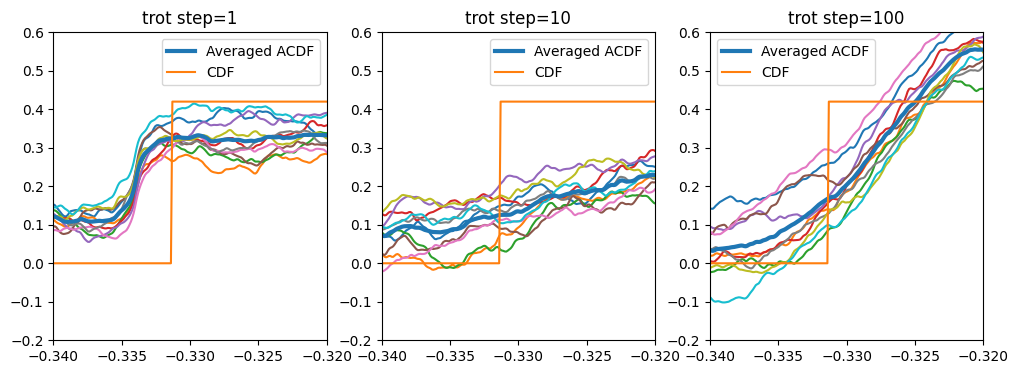

In [50]:
fig, ax = plt.subplots(1,len(ACDF_list),figsize=(12,4))
x_list = np.linspace(-pi/3,pi/3,precision)

for i in range(len(ACDF_list)):
    for j in range(rep):
        ax[i].plot(x_list, ACDF_list[i][j])
    ax[i].plot(x_list, np.mean(ACDF_list[i],axis=0),linewidth=3,label='Averaged ACDF')
    ax[i].set_title('trot step='+str(step_list[i]))
    ax[i].plot(x_list, CDF,label='CDF')
    ax[i].set_xlim([-.34,-.32])
    ax[i].set_ylim([-.2,.6])
    ax[i].legend()